# TalkingData AdTracking 데이터의 탐색적 분석 (Exploratory data analysis)
### 0. 데이터 필드 정보 및 의견
  - `ip`: ip address of click
  - `app`: app id for marketing
  - `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
  - `os`: os version id of user mobile phone
  - `channel`: channel id of mobile ad publisher
  - `click_time`: timestamp of click (UTC)
  - `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
    * 데이터 필드 중 유일하게 attributed_time 은 학습 데이터에만 존재하는데 다른 필드 데이터들로 하여금 테스트 데이터 내에 이 필드값의 예측치를 채워넣을 수 있을지 모르니  **반드시 확인하는 작업을 진행할 계획**입니다. 
  - `is_attributed`: the target that is to be predicted, indicating the app was downloaded

### 1. Upvote 1위의 EDA 자료를 요약 (by anokas)
- 자료 링크 - https://www.kaggle.com/anokas/talkingdata-adtracking-eda
  
- 예측 확률에 따라 평가되는 LogLoss 방식과는 달리 0, 1을 확실히 구분해내는 것이 중요한 AUROC 평가에 해당합니다.
    > 확률의 리스케일링 (상수 및 승수의 추가) 는 스코어에 영향이 없습니다.
  
- 압축된 1.8Gb 의 학습 데이터는 압축을 해제하면 무려 7.5Gb
    ```bash
    # File sizes
    train.csv                     7537.65MB
    test.csv                      863.27MB
    sample_submission.csv         195.58MB
    train_sample.csv              4.08MB

    # Line count:
    184903891 ../input/train.csv
    18790470 ../input/test.csv
    100001 ../input/train_sample.csv

    ```
    
- 저자는 백만개 라인만 입력으로 사용하였습니다.
- 데이터값이 전부 인코딩되어 있어서 다양한 차트를 통해 얻을 수 있는 인사이트가 **제한**됩니다.
- 그러므로, 저자는 각 필드의 인코딩값의 유니크수, 인코딩 값별 빈도수의 분포도, 빈도수별 ID수를 나타내는 히스토그램 세가지 차트를 확인하였습니다.
    * 약 4만 정도 index 근처 몇개 ip 들이 월등히 높은 6000 이상의 클릭수를 보이고 있습니다.
    * app 은 명확하진 않지만 index 180 근처에 조금은 집중된 모습입니다.
    * device 는 index 290 근처에 매우 높은 클릭수를 보인 1개 정도의 device 값이 있는 것이 확인됩니다.
    * os 도 index 160 근처에서 높은 클릭수를 보인 2개 정도의 os 값이 확인됩니다.
- 위 차트에서 확인한 것처럼 매우 극히 일부분의 필드값에 대해서만 Fraudulent 판정이 된 것으로 예상할 수 있습니다.
    * 백만개 라인 중 겨우 0.17% 가 Fraudulent 라고 판정된 데이터로 **결론적으로 매우 불균형적으로 학습될 수 있는 데이터이므로 over 또는 under 샘플링이 반드시 필요할 것으로 보입니다.**
    * **또는, 적절한 뉴럴넷의 하이퍼 파라미터 조정을 통해 이를 극복하거나 내부적으로 적절히 샘플링에 대응하는 Boolean 하이퍼 파라미터들을 포함하는 XGBoost, LightGBM 을 적용해보는 것이 좋은 방향 같습니다.**

### 2. EDA

In [1]:
%%html
<!-- 에디터 폰트를 조정합니다. -->
<style type='text/css'>
.CodeMirror{
    font-size: 16px;
    font-family: D2Coding;
</style>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("./data"))

['train_sample.csv.zip', 'sample_submission.csv.zip', 'test.csv', 'mnt', 'test.csv.origin', '.ipynb_checkpoints', 'train.csv.zip', 'train.csv', 'talkingdata_EDA_wonkyun.ipynb', 'test_supplement.csv.zip', 'test.csv.zip']


In [3]:
# make wider graphs
sns.set(rc={'figure.figsize':(12,8)});
plt.figure(figsize=(12,8));

<Figure size 864x576 with 0 Axes>

In [4]:
# import all rows of train and all test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [8]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [9]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,43570,3,1,18,379,2017-11-09 14:23:39
1,1,80528,3,1,13,379,2017-11-09 14:23:51
2,2,32323,3,1,13,379,2017-11-09 14:25:57
3,3,42887,3,1,17,379,2017-11-09 14:26:03
4,4,119289,58,1,30,120,2017-11-09 14:26:41


describe 함수를 사용하여 category, datetime 측면의 정보를 얻기위해 type 을 설정합니다.

In [5]:
categorical_fields = ['ip', 'app', 'device', 'os', 'channel']
for field in categorical_fields:
    train[field] = train[field].astype('category')
    test[field]=test[field].astype('category')
train['is_attributed']=train['is_attributed'].astype('category')
test['click_id']=test['click_id'].astype('category')
    
# set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

top 는 most common value 를 의미합니다. 그리고 그 반복횟수가 freq 입니다.

In [9]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,184903890.0,184903890.0,184903890.0,184903890.0,184903890.0,184903890,456846,184903890.0
unique,277396.0,706.0,3475.0,800.0,202.0,259620,182057,2.0
top,5348.0,3.0,1.0,19.0,280.0,2017-11-07 14:00:11,2017-11-08 14:16:29,0.0
freq,1238734.0,33911780.0,174330052.0,44181914.0,15065927.0,1502,14,184447044.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 16:00:00,NaN


In [17]:
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,57537505.0,57537505.0,57537505.0,57537505.0,57537505.0,57537505.0,57537505
unique,57537505.0,126414.0,536.0,3032.0,607.0,186.0,86945
top,57537504.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,504147.0,9066687.0,53545440.0,13424328.0,3673594.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-09 14:23:39
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 16:00:00


필드별 유니크한 값 카운트입니다. ip 필드가 특별히 많은 유니크수를 보이고 있어서,
이들이 잘 분류(그룹)시킬 수 있다면 학습 데이터의 차원(Dimension)수를 줄여 모델 구축 속도를 개선함으로써 더 큰 볼륨의 학습 데이터를 가지고 모델을 만들어 볼 수 있을 것이라고 생각해보았습니다.

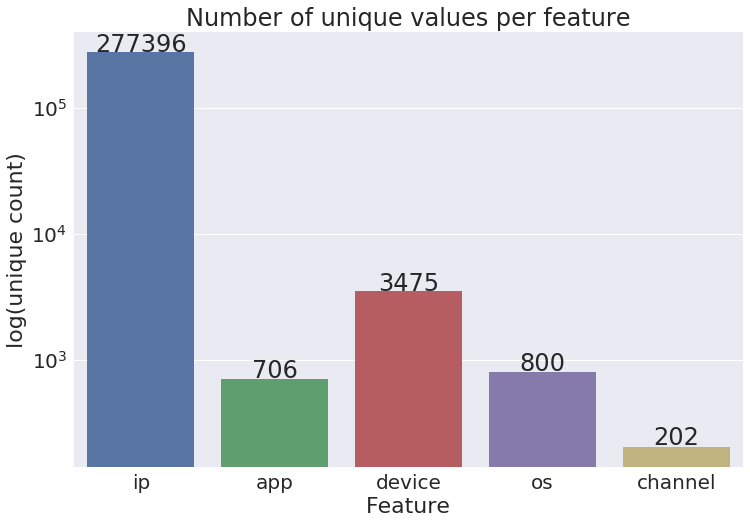

In [51]:
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]

sns.set(font_scale=2)
pal = sns.color_palette()
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')

for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

Not Fradulent 클래스의 데이터가 대부분임에 주의해야합니다.

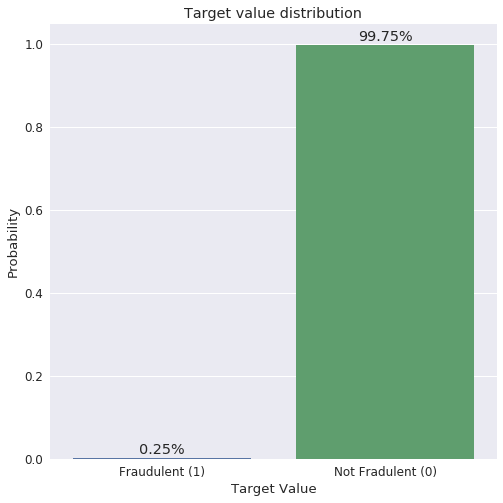

In [52]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['Fraudulent (1)', 'Not Fradulent (0)'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

Fraud 에 해당하는 데이터의 오버샘플링을 고려할때 ip 값의 range 에 따라 가중치를 둘수 있을 것 같습니다.

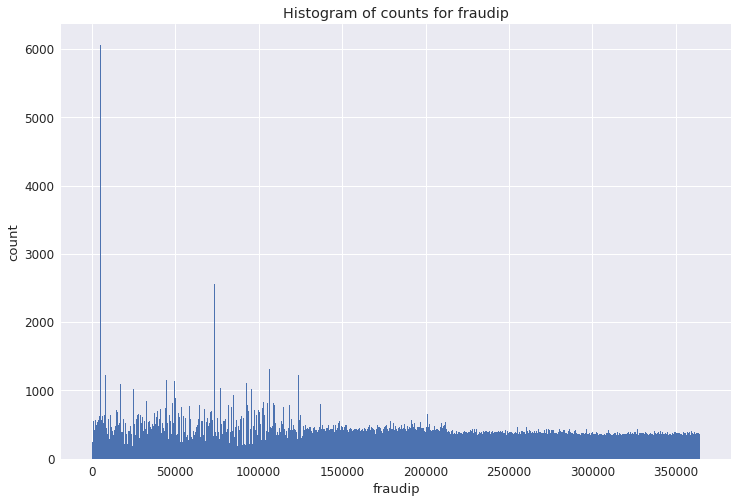

In [12]:
fraudip = train[["ip", "is_attributed"]][train["is_attributed"]==1]["ip"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.hist(fraudip, bins=1000)
plt.title("Histogram of counts for {}".format('fraudip'))
plt.ylabel('count')
plt.xlabel('fraudip')
plt.show()

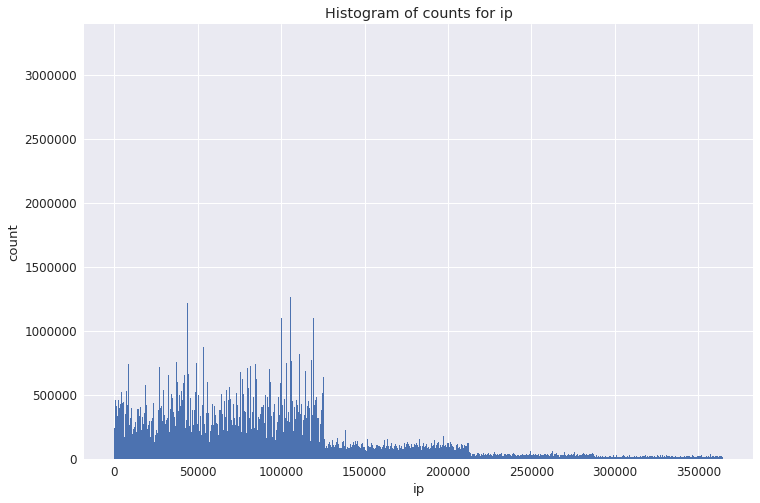

In [13]:
ip = train["ip"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.hist(ip, bins=1000)
plt.title("Histogram of counts for {}".format('ip'))
plt.ylabel('count')
plt.xlabel('ip')
plt.show()

conversion time, app 이 동일한 경우의 카운트를 보면 0 부근의 값을 가진 앱들이 주로 단순한 반복성 어뷰징의 대상이 되는 것을 확인하였습니다.

In [6]:
df_fraud = train[['app', 'click_time', 'attributed_time']].query('attributed_time != "NaT"')
df_fraud['conversion_time'] = df_fraud['attributed_time'] - df_fraud['click_time']

df_app_count = df_fraud[['app', 'click_time', 'attributed_time', 'conversion_time']].groupby(['app'], as_index=False)\
    .size()\
    .reset_index(name='app_unique_count')

df_app_conversion_count = df_fraud[['app', 'click_time', 'attributed_time', 'conversion_time']]\
    .groupby(['app', 'conversion_time'], as_index=False)\
    .size()\
    .reset_index(name='app_conversion_time_unique_count')\
    .sort_values('app_conversion_time_unique_count', ascending=False)

df_app_conversion_count.head(10);
    
#df_app_conversion_count.merge(df_app_count, on=['app'])
    
#ax = sns.jointplot(x='app', y='count', data=df_app_conversion_count)
#ax.set_axis_labels(xlabel='app', ylabel='fraud count from same conversion time')

ip, device, os 모두를 조작하면서 어뷰징하는 fraud 가 얼마나 되는지 확인하기위해 ip, device, os 별 그룹 카운트 해보았습니다.

ip, device, os 그룹의 값이 전체 데이터셋에서 유일한 경우가 전체 fraud(또는 attributor)의 약 90% 를 차지합니다.

ip, device, os 그룹의 유니크수가 전체 데이터셋에서 1, 2 인 경우의 합은 전체의 약 96% 에 해당합니다. 

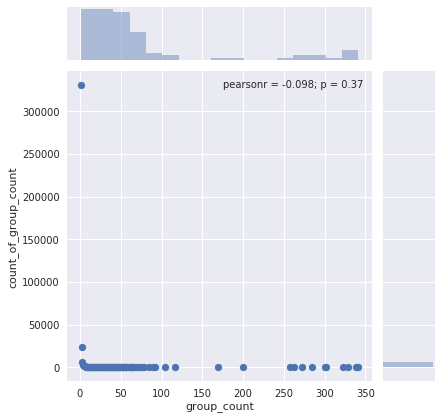

count_of_group_count    368695
dtype: int64


,group_count,count_of_group_count
0,1,330615


In [15]:
df_fraud = train[['ip', 'device', 'os', 'is_attributed']].query("is_attributed == 1")
df_fraud_unique_useragent = df_fraud.groupby(['ip', 'device', 'os'])\
    .size().reset_index(name='group_count')
df_fraud_count_of_unique_count = df_fraud_unique_useragent[['group_count']].groupby(['group_count'])\
    .size().reset_index(name='count_of_group_count')
    
sns.jointplot(x='group_count', y='count_of_group_count', data=df_fraud_count_of_unique_count)
plt.show()


print(df_fraud_count_of_unique_count.agg({'count_of_group_count' : 'sum'}))
df_fraud_count_of_unique_count.query("count_of_group_count > 300000")

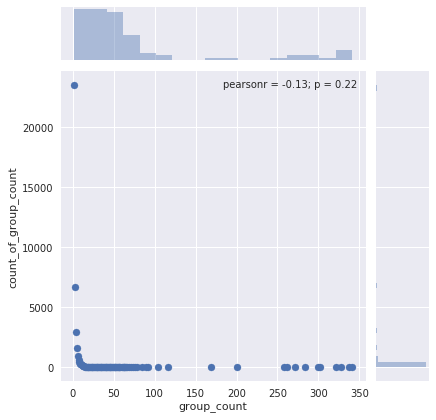

count_of_group_count    38080
dtype: int64


,group_count,count_of_group_count
1,2,23495


In [16]:
df_fraud = train[['ip', 'device', 'os', 'is_attributed']].query("is_attributed == 1")
df_fraud_unique_useragent = df_fraud.groupby(['ip', 'device', 'os'])\
    .size().reset_index(name='group_count')
df_fraud_count_of_unique_count = df_fraud_unique_useragent[['group_count']].groupby(['group_count'])\
    .size().reset_index(name='count_of_group_count').query("count_of_group_count < 300000")

sns.jointplot(x='group_count', y='count_of_group_count', data=df_fraud_count_of_unique_count)
plt.show()

print(df_fraud_count_of_unique_count.agg({'count_of_group_count' : 'sum'}))
df_fraud_count_of_unique_count.query("count_of_group_count > 20000")

ip, device, os 그룹의 유니크 카운트의 카운트가 1인 경우에 다운로드 받지 않은 경우도 많기 때문에 추가적으로 둘을 구분할 수 있는 feature 를 찾아봐야겠다고 생각하였습니다.

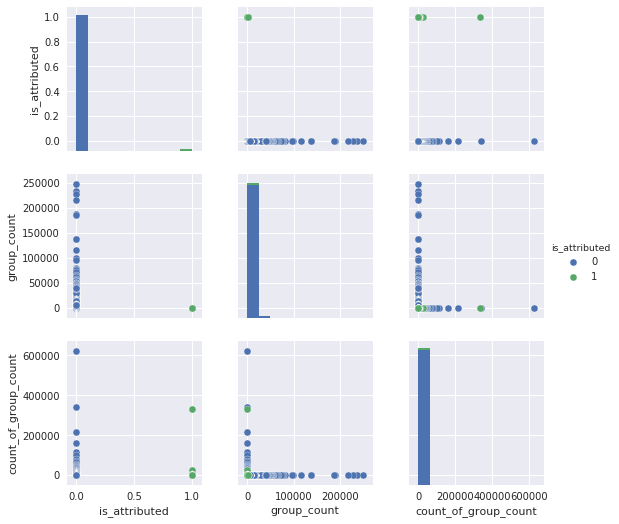

In [7]:
df_useragent_attribute = train[['ip', 'device', 'os', 'is_attributed']]
df_useragent_group_count = df_useragent_attribute\
    .groupby(['ip', 'device', 'os', 'is_attributed'])\
    .size()\
    .reset_index(name='group_count')
    
df_count_of_group_count = df_useragent_group_count\
    .groupby(['is_attributed', 'group_count'])\
    .size()\
    .reset_index(name='count_of_group_count')\
    .sort_values(['count_of_group_count'], ascending=False)
    
sns.pairplot(hue='is_attributed', data=df_count_of_group_count)
plt.show()

In [49]:
df_useragent_unqiue = df_useragent_group_count.query("group_count == 1")

df_train_useragent_group_count_added = pd.merge(train, df_useragent_unqiue, how='inner', on=['ip', 'device', 'os', 'is_attributed'])
df_train_useragent_group_count_added.head(10)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,group_count
0,164537,58,1,19,120,2017-11-06 15:14:35,NaT,0,1
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,1
2,176414,82,1,57,224,2017-11-06 15:41:34,NaT,0,1
3,94733,64,1,58,459,2017-11-06 15:46:17,NaT,0,1
4,78853,64,1,4,459,2017-11-06 15:47:05,NaT,0,1
5,212224,3,1,13,379,2017-11-06 15:48:39,NaT,0,1
6,200957,64,1,42,459,2017-11-06 15:50:27,NaT,0,1
7,153590,3,1,15,379,2017-11-06 15:51:20,NaT,0,1
8,165267,58,1,13,120,2017-11-06 15:51:51,NaT,0,1
9,114890,64,1,9,459,2017-11-06 15:54:54,NaT,0,1


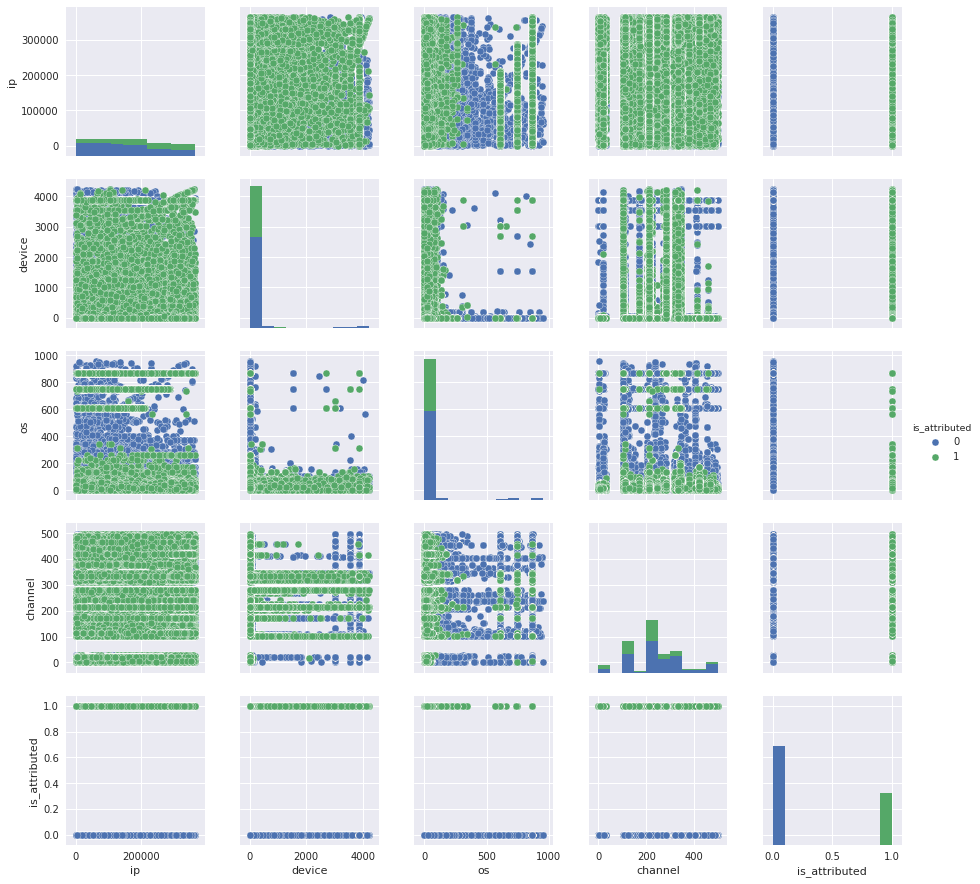

In [50]:
df_train_except_useragent = df_train_useragent_group_count_added[['ip', 'device', 'os', 'channel', 'click_time', 'is_attributed']]

sns.pairplot(hue='is_attributed',  data=df_train_except_useragent)
plt.show()

In [1]:
# round the time to nearest unit time
df_train_except_useragent['click_time_minute'] = df_train_except_useragent['click_time'].dt.round('1min')  
df_train_except_useragent['click_time_hour'] = df_train_except_useragent['click_time'].dt.round('H')  
df_train_except_useragent['click_time_minute'] = df_train_except_useragent['click_time_minute'].dt.strftime('%Y-%m-%d %H:%M');
df_train_except_useragent['click_time_hour'] = df_train_except_useragent['click_time_hour'].dt.strftime('%Y-%m-%d %H');

df_minute_count = df_train_except_useragent\
    .groupby(['click_time_minute', 'is_attributed'])\
    .size()\
    .reset_index(name='each_minute_count')
    
df_hour_count = df_train_except_useragent\
    .groupby(['click_time_hour', 'is_attributed'])\
    .size()\
    .reset_index(name='each_hour_count')

sns.tsplot(df_minute_count, time='click_time_minute', 
            unit="is_attributed", 
            condition='is_attributed', 
            value='each_minute_count')
plt.show()

sns.tsplot(df_hour_count, time='click_time_hour', 
            unit="is_attributed", 
            condition='is_attributed', 
            value='each_hour_count')
plt.show()

NameError: name 'df_train_except_useragent' is not defined

 **(결론)** - ip, os ,device 의 그룹 유니크 카운트 별로 다운로드 받은 수의 비율을 특징 벡터로 추가해보면 어떨까? 

In [8]:
df_gcnt_cgcnt_no_down = df_count_of_group_count[['group_count', 'count_of_group_count', 'is_attributed']]\
    .query('is_attributed == 0')

df_gcnt_cgcnt_is_down = df_count_of_group_count[['group_count', 'count_of_group_count', 'is_attributed']]\
    .query('is_attributed == 1')
df_gcnt_cgcnt_no_down['no_down_cgcnt'] = df_gcnt_cgcnt_no_down['count_of_group_count']
df_gcnt_cgcnt_is_down['is_down_cgcnt'] = df_gcnt_cgcnt_is_down['count_of_group_count']

df_gcnt_cgcnt_join = pd.merge(\
        df_gcnt_cgcnt_is_down[['group_count', 'is_down_cgcnt']],
        df_gcnt_cgcnt_no_down[['group_count', 'no_down_cgcnt']],
        how='inner', on=['group_count'])
df_gcnt_cgcnt_join.head(10)

,group_count,is_down_cgcnt,no_down_cgcnt
0,1,330615,623589
1,2,23495,340932
2,3,6656,216894
3,4,2921,158405
4,5,1587,113827
5,6,938,100716
6,7,580,80693
7,8,418,71887
8,9,312,62364
9,10,247,55740


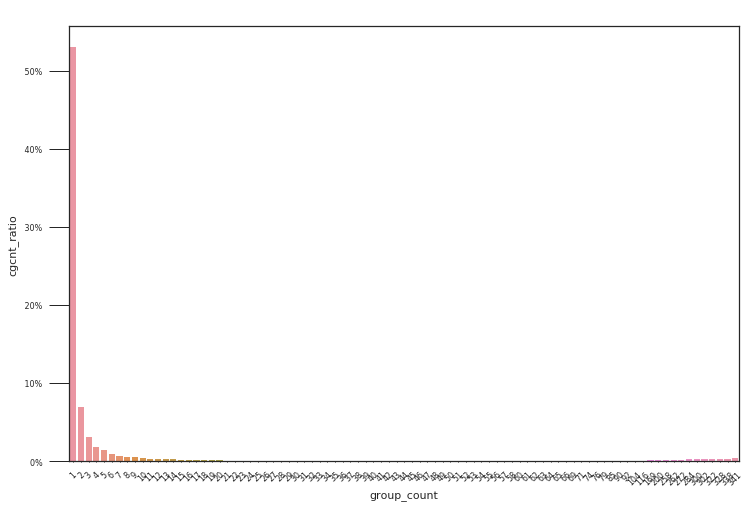

In [47]:
df_gcnt_cgcnt_join['cgcnt_ratio'] = df_gcnt_cgcnt_join['is_down_cgcnt'] / df_gcnt_cgcnt_join['no_down_cgcnt']
df_result = df_gcnt_cgcnt_join[['group_count', 'cgcnt_ratio']]
df_result['cgcnt_ratio'] = df_result['cgcnt_ratio']

g = sns.barplot(x="group_count", y="cgcnt_ratio", data=df_result)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.tick_params(labelsize=8)
vals = g.get_yticks()
g.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.show()

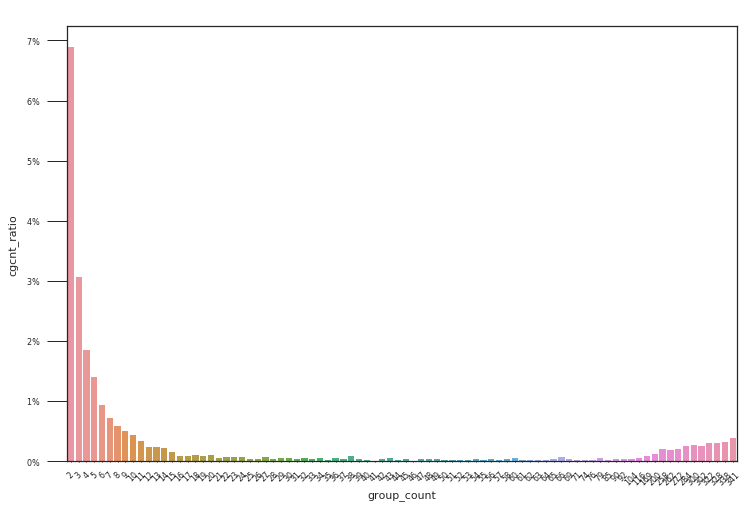

In [49]:
g = sns.barplot(x="group_count", y="cgcnt_ratio", data=df_result.query('group_count != 1'))
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.tick_params(labelsize=8)
vals = g.get_yticks()
g.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.show() 

ip, device, os 그룹 카운트를 전체 트레이닝 데이터셋에서 확인해봄과 동시에,

**ip, device, os 페어의 조합별 특징을 살펴보았습니다.** 

맨 오른쪽 열의 그래프들을 확인하면 역시 그룹 카운트 1인 경우에 attributor 가 집중되어있습니다.

그나마 히스토그램 상에서 고루 분포되어있는, 맨 왼쪽 열 ip 그래프를 확인해보면 os 값에서 특징이 보입니다.

os 값에서는 구분되는 3개의 직선이 보이고 이는 ip 만 바꿔가면서 특정 3개 os 에서 어뷰징을 시도한 것으로 보입니다. 더 나아가서는 ip 에 대한 1행의 그래프들 중 device, os 에 대한 그래프를 자세히 보면 특정 ip 대역폭으로 device, os 의 3개 값이 동일 높이로 보입니다. 즉, device 와 os 는 변경하지 않으면서 ip 만 특정 대역별로 조작하는 어뷰저로 판단하고, **테스트셋에서 이러한 어뷰저를 예측해낼때 유리한지 아니면, 여러 캐글유저의 의견처럼 단순히 attributor 를 예측해내는 것이 맞는 것인지** 모델의 성능을 보고 결정해야할 것 같습니다.

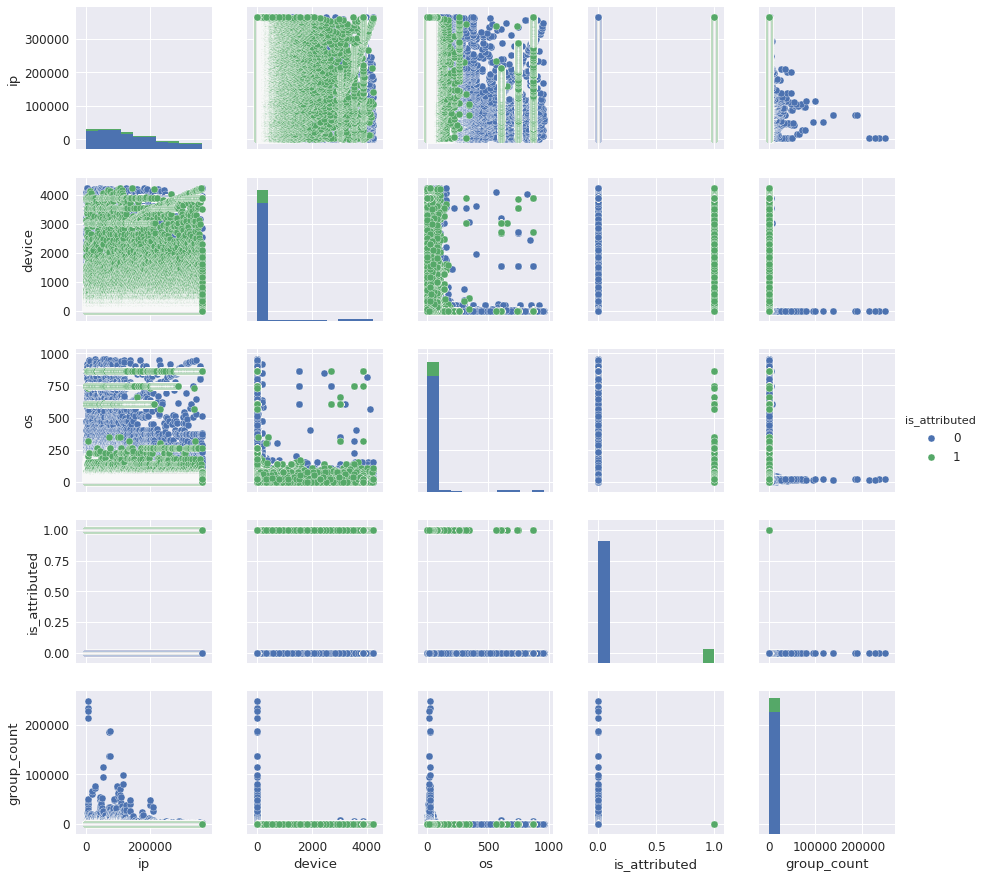

In [160]:
df_unique_useragent = train[['ip', 'device', 'os', 'is_attributed']].groupby(['ip', 'device', 'os', 'is_attributed'])\
    .size().reset_index(name='group_count')

sns.pairplot(hue='is_attributed',  data=df_unique_useragent)
plt.show()